In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    root = os.path.dirname(os.path.realpath(__file__))
except:
    root = os.getcwd()
    
sys.path.append(os.path.join(root, '..'))

from fmi_mlc import fmi_gym
from fmi_mlc import get_default_parameter

### Default Parameter

All available parameters of fmi_gym are documented in the get_default_parameter function:

In [2]:
help(get_default_parameter)

Help on function get_default_parameter in module fmi_mlc.fmi_gym_parameter:

get_default_parameter()
    Returns the default parameters for fmi_gym. Description:
    
    fmi_gym parameter:
        precision (str): Precision of data exchange, default 'float32'.
        seed (int): Seed for np.random, default None.
        preprocessor (#classA): Custom Python function to pre-process data before FMU, default None.
        postprocessor (#classA): Custom Python function to post-process data after FMU, default None.
        reset_on_init (bool): Reset environment when initializing, default False. 
        store_data (bool): Store inputs, FMU outputs, and reward in self.data, default False.
        init_fmu (bool): Initialize FMU when fmi_gym resets, default True.
        stateprocessor (#classA): Custom Python function to midify state object, default None.
        resetprocessor (#classB): Custom Python function executed on fmi_gym reset, default None.
    fmu parameter:
        fmu_step_

### Setup Experiment

To illustrate the functionality of FMI-MLC and the fmi_gym, an FMU model consisting of a Battery and PV system is used. The FMU takes the external battery control signal "BattCtrl" as input, computes the weather dependent PV generation (Note: using San Francisco weather in this example) to compute the site active power, in Watt, and the maximal absolute power as reward. Since internal dynamics (weather data) change every hour, a 30 minute timestep is chosen. 

In [3]:
parameter = {}
# fmi_gym parameter
parameter['seed'] = 1
parameter['store_data'] = True

# fmu parameter
dtype = np.float64
parameter['fmu_step_size'] = 30*60
parameter['fmu_path'] = os.path.join(root, 'fmus', 'PVandBatt.fmu')
parameter['fmu_start_time'] = 0
parameter['fmu_warmup_time'] = 3*60*60
parameter['fmu_final_time'] = 24*60*60
parameter['fmu_param'] = {'PV.weather_file': os.path.join(root, 'fmus', 'USA_CA_San.Francisco.Intl.AP.724940_TMY3.mos')}

# data exchange parameter
parameter['input_labels'] = ['BattCtrl']
parameter['action_names'] = ['BattCtrl']
parameter['action_min'] = np.array([-1e3], dtype=dtype)
parameter['action_max'] = np.array([1e3], dtype=dtype)
parameter['observation_names'] = ['PV.P', 'Battery.P', 'Battery.SOC', 'P']
parameter['reward_names'] = ['Pmax_neg']

env = fmi_gym(parameter)

### Simulate

The simulation raondomly samples the action space at each iteration and passes the action to the environment to produce a new step. The simulation is conducted until the environment completes (i.e., environment time >= final time).

In [4]:
done = False
state = env.reset()
while not done:
    action = env.action_space.sample()
    state, reward, done, info = env.step(action)
    if done:
        res = env.data.copy(deep=True)
        state = env.reset()
env.close()

In [5]:
res.index = [pd.to_datetime('2021-01-01') + pd.DateOffset(seconds=ix) for ix in res.index]
#print(res.set_index('time').round(1))

### Plot

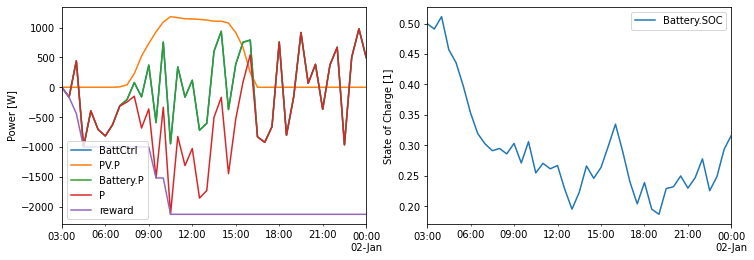

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=False)
axs = axs.ravel()
res[['BattCtrl', 'PV.P', 'Battery.P', 'P', 'reward']].plot(ax=axs[0])
axs[0].set_ylabel('Power [W]')
res[['Battery.SOC']].plot(ax=axs[1])
axs[1].set_ylabel('State of Charge [1]')
plt.show()